In [106]:
import glob
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import datetime
import dateutil.parser as parser
%matplotlib inline
plt.style.use('ggplot')

### Zika data

In [16]:
# master dataframe
cdcUSA = pd.read_csv("cdcUSA.csv", usecols = ['report_date','location','data_field','value'])
# reindex to get rid of 'United_States-' prefix
cdcUSA.location = [x[len('United_States-'):] for x in cdcUSA.location]
# replace "_" with " " in location
cdcUSA.location = cdcUSA.location.apply(lambda x: x.replace("_"," "))
# remove District of Columbia
cdcUSA = cdcUSA[cdcUSA.location != 'District of Columbia']

In [17]:
cdcUSA.head(4)

,report_date,location,data_field,value
0,2016-02-24,Alabama,zika_reported_travel,1
1,2016-02-24,Alabama,zika_reported_local,0
2,2016-02-24,American Samoa,zika_reported_local,4
3,2016-02-24,American Samoa,zika_reported_travel,0


#### without multiindex

In [18]:
# make dataframe of total cases separated by local and travel
zika_counts = cdcUSA.groupby(['location','data_field']).sum().value.unstack('data_field')
# add missing states
zika_counts.loc['Alaska'] = 0
zika_counts.loc['Idaho'] = 0
zika_counts.loc['North Dakota'] = 0
zika_counts.loc['South Dakota'] = 0
zika_counts.loc['Wyoming'] = 0
# sort alphabetical order
zika_counts.sort(inplace=True)

/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [19]:
zika_counts.head(2)

data_field,zika_reported_local,zika_reported_travel
location,,
Alabama,0,165
Alaska,0,0


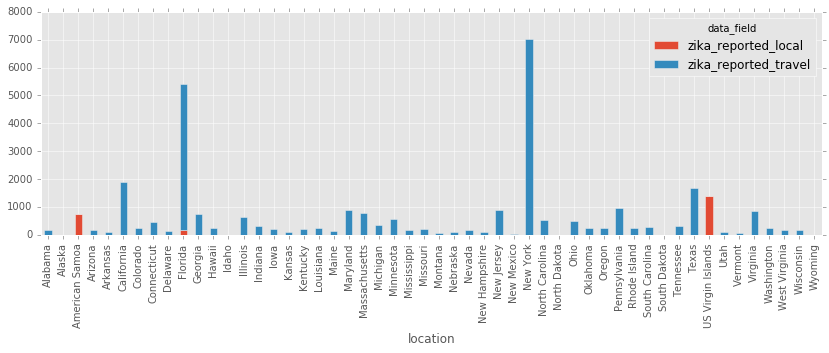

In [20]:
# remove PR and plot
zika_counts_noPR = zika_counts.drop('Puerto Rico')
zika_counts_noPR.plot(kind='bar',stacked=True, figsize=(14,4))

#### with multiindex

In [21]:
# make multiindex
cdcUSA.set_index(['location','report_date'], inplace=True)

#### separate local and travel dataframes

In [22]:
# make local and travel dataframes
cdcUSA_local = cdcUSA[cdcUSA.data_field == 'zika_reported_local']
cdcUSA_travel = cdcUSA[cdcUSA.data_field == 'zika_reported_travel']
cdcUSA_local.drop('data_field',axis=1,inplace=True)
cdcUSA_travel.drop('data_field',axis=1,inplace=True)

/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### add missing states

In [23]:
# list of missing states
missing_states = ['Alaska','Idaho','North Dakota','South Dakota','Wyoming']
# list of unique dates
dates = set([x[1] for x in cdcUSA_local.index])
# add 0 for missing states
for state in missing_states:
    for date in dates:
        cdcUSA_local.ix[(state,date),:] = 0
        cdcUSA_travel.ix[(state,date),:] = 0
# sort alphabetical order
cdcUSA_local.sort(inplace=True)
cdcUSA_travel.sort(inplace=True)

/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(....) is deprecated, use sort_index(.....)
/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [24]:
# # explore whether zika data is cumulative or not
# states = set([x[0] for x in cdcUSA_travel.index])
# states = list(states)
# for i in range(len(states)):
#     print states[i]
#     cdcUSA_travel.xs(states[i],level='location').plot()

### OAG data

In [27]:
### OAG flight stuff
oag = pd.read_csv('OAGJAN13.csv')

# take out relevant columns
oag_subset = oag[['depctry','arrctry','arrcity','days','efffrom','effto','seats','distance']]

# turn days into number of days
oag_subset.days = [len(x) for x in oag_subset.days]

# translate fromday (str) to number of days from beginning of 2016 (int)
# same for today
fromdays = np.array(map(lambda x: int(x[-2:]) + 30*(int(x[-4:-2])-1), oag_subset.efffrom.astype(str)))
todays = np.array(map(lambda x: int(x[-2:]) + 30*(int(x[-4:-2])-1),oag_subset.effto.astype(str)))

# only interested in up to Sept 14 (since only have Zika data for then)
todays[todays > 257] = [257]*len(todays[todays > 257]) # cannot end after Sept 14
oag_subset['fromdays'] = fromdays
oag_subset['todays'] = todays
oag_subset['flights'] = ((todays - fromdays)/7.0 * oag_subset['days'].astype(int)) # calculate flights
oag_subset = oag_subset.ix[oag_subset.fromdays < 257] # cannot start after Sept 14
# round to integer
oag_subset.flights = np.round(oag_subset.flights)

# remove unneeded columns 'effrom' 'effto' etc
oag_subset = oag_subset[['depctry','arrctry','arrcity','seats','distance','flights']]

# only interested in BR to US
oag_subset = oag_subset[(oag_subset.depctry == 'BR') & (oag_subset.arrctry == 'US')]

/Users/amandazhang/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (51,53,54,55,56,58,60,62,64,66,68,70,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/amandazhang/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.h

In [28]:
# calculate total_seats and flights for each route
oag_subset['total_seats_oag'] = oag_subset.seats * oag_subset.flights
total_seats_oag = oag_subset['total_seats_oag'].groupby(oag_subset.arrcity).sum()
flights_oag = oag_subset['flights'].groupby(oag_subset.arrcity).sum()

In [29]:
# consolidate
oag_data = pd.DataFrame([total_seats_oag,flights_oag]).T
# group by state instead of arrcity
state = ['Georgia','Massachusetts','Illinois','North Carolina','Texas','Michigan','Texas',
         'California','Florida','New York','Florida','California','Washington']
oag_data.index = state
oag_data = oag_data.groupby(oag_data.index).sum()
oag_data.columns = ['total_seats_oag','flights_oag']

In [30]:
oag_data

,total_seats_oag,flights_oag
California,220248.0,917.0
Florida,1961505.0,10561.0
Georgia,291126.0,1250.0
Illinois,203364.0,756.0
Massachusetts,3444.0,14.0
Michigan,52290.0,249.0
New York,1426618.0,5422.0
North Carolina,84816.0,384.0
Texas,256096.0,1076.0
Washington,493615.0,1835.0


### BTS data

In [8]:
### BTS data
#bts_data = pd.read_csv('stateflightdata_jan_june.csv', index_col = 'State')
#bts_data.drop('abr', axis=1, inplace=True)

### Connectivity data

In [42]:
connect = pd.DataFrame([['Florida', 434.69616252523247], ['New York', 440.04009010061714], ['California', 444.85409595129727], ['Texas', 455.8554103313701], ['Illinois', 468.8176337993529], ['Georgia', 473.31074347467], ['Washington D.C.', 538.5363106259356], ['North Carolina', 541.3294184313457], ['Colorado', 572.0684725046116], ['Nevada', 574.6588617975838], ['Washington', 576.1148633780251], ['Arizona', 577.2711790627785], ['Michigan', 582.580235623788], ['Massachusetts', 587.1065703311507], ['Minnesota', 602.7468429554243], ['Missouri', 695.2574644835706], ['Ohio', 722.3612803945238], ['Maryland', 754.2498835598093], ['Tennessee', 762.7879232826781], ['Utah', 774.4329545629312], ['Oregon', 776.6670499428964], ['Hawaii', 781.5533687270126], ['Louisiana', 837.873690862505], ['Pennsylvania', 945.0532504798132], ['Kentucky', 1035.8216718619483], ['Indiana', 1055.267974385317], ['Wisconsin', 1068.96931656824], ['Virginia', 1152.7144988011262], ['Oklahoma', 1229.1530422850385], ['South Carolina', 1247.0510451239763], ['Connecticut', 1586.9933949590088], ['Alabama', 1594.4785722262145], ['New Mexico', 1613.1637313056535], ['Nebraska', 1730.2899060273187], ['Alaska', 1863.301594404632], ['Arkansas', 2039.8009853435462], ['Iowa', 2045.2632717411666], ['Idaho', 2383.462328130591], ['Rhode Island', 2615.9380937612636], ['Montana', 2954.2612119150044], ['Maine', 3246.098649851817], ['Kansas', 3421.613158628434], ['Mississippi', 3515.868733425839], ['North Dakota', 3814.9784475603174], ['New Hampshire', 4010.967055968573], ['South Dakota', 5456.386019572374], ['Vermont', 5787.906798157988], ['Wyoming', 7881.000598155415], ['New Jersey', 9099.081839271023], ['West Virginia', 9436.999356367092], ['Delaware', 24879.120527832612], ['US Virgin Islands', 4696.2], ['American Samoa', 129604.6], ['Puerto Rico', 1240.4]])
connect.columns = [['State','connectivity']]
connect.connectivity = 1/connect.connectivity
connect.set_index('State', inplace=True)
connect.sort(inplace=True)

/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [43]:
connect.head()

,connectivity
State,
Alabama,0.000627
Alaska,0.000537
American Samoa,0.000008
Arizona,0.001732
Arkansas,0.000490


### Other data (pop, temp, mosquito)

In [44]:
### Population data
pop_data = pd.read_csv('state_populations.csv', index_col = 'State')
pop_data['pop'] = map(lambda x: int(x.replace(',','')), pop_data['pop']) # string to int
pop_data.sort(inplace=True)

/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [45]:
### temperature data
temp = pd.read_csv('usa_avg_summer_temp.csv', index_col='State')

In [46]:
temp_by_month = pd.read_csv('US2013temps.csv',usecols=['AverageTemperature','State','Month'])

In [47]:
### mosquito data from Russell
mosquito = pd.read_csv('mosquitodata.csv', index_col=0)
mosquito.sort(inplace=True)

/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  app.launch_new_instance()


### Put everything together for master df

In [48]:
# make master dataframe
master = pd.DataFrame({})
master['zika_counts'] = zika_counts.zika_reported_travel
master['temp'] = temp
master['pop'] = pop_data
master['mosquito'] = mosquito['Number of occurences (1960-2016)']
master['total_seats_oag'] = oag_data.total_seats_oag
master['flights_oag'] = oag_data.flights_oag
master['connectivity'] = connect.connectivity
#master['passengers_bts'] = bts_data.passengers

In [49]:
master.fillna(0, inplace=True)
master = master.sort()

/Users/amandazhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


In [50]:
master.shape

(53, 7)

In [51]:
master.head(10)

,zika_counts,temp,pop,mosquito,total_seats_oag,flights_oag,connectivity
location,,,,,,,
Alabama,165,78.6,4863300,55.0,0.0,0.0,0.000627
Alaska,0,52.3,741894,0.0,0.0,0.0,0.000537
American Samoa,4,86.0,54343,12.0,0.0,0.0,0.000008
Arizona,175,78.1,6931071,48.0,0.0,0.0,0.001732
Arkansas,117,78.8,2988248,25.0,0.0,0.0,0.000490
California,1881,73.4,39250017,53.0,220248.0,917.0,0.002248
Colorado,260,65.2,5540545,1.0,0.0,0.0,0.001748
Connecticut,465,69.2,3576452,0.0,0.0,0.0,0.000630
Delaware,152,74.2,952065,6.0,0.0,0.0,0.000040


In [52]:
master.to_csv('master.csv')

### Regressions

In [53]:
# regression time!
# make x and y
y = master.zika_counts

x = master.drop('zika_counts', axis=1)
x_flightsonly = x[['temp','pop','mosquito','flights_oag']]
x_commuteonly = x[['temp','pop','mosquito','connectivity']]

# scale
x = preprocessing.scale(x)
x_flightsonly = preprocessing.scale(x_flightsonly)
x_commuteonly = preprocessing.scale(x_commuteonly)

In [83]:
# split into train and test
model = linear_model.LassoCV(cv=30)
model.fit(x,y)
print 'Regression Baseline model\n'
print 'coef_temp: ', round(model.coef_[0],2)
print 'coef_pop: ', round(model.coef_[1],2)
print 'coef_mosquito: ', round(model.coef_[2],2)
print 'coef_seats: ', round(model.coef_[3],2)
print 'coef_flights: ', round(model.coef_[4],2)
print 'coef_commute_time: ', round(model.coef_[5],2)
print 'intercept: ', round(model.intercept_,2)

Regression Baseline model

coef_temp:  -0.0
coef_pop:  195.31
coef_mosquito:  -0.0
coef_seats:  850.07
coef_flights:  0.0
coef_commute_time:  0.0
intercept:  559.94


In [84]:
# model flights only
x_flightsonly_train, x_flightsonly_test, y_flightsonly_train, y_flightsonly_test = train_test_split(x_flightsonly, y, 
                                                    test_size=0.2)

model_flightsonly = linear_model.LassoCV(cv=30)
model_flightsonly.fit(x_flightsonly_train,y_flightsonly_train)
print 'Regression Flights-only model\n'
print 'coef_temp: ', round(model_flightsonly.coef_[0],2)
print 'coef_pop: ', round(model_flightsonly.coef_[1],2)
print 'coef_mosquito: ', round(model_flightsonly.coef_[2],2)
print 'coef_flights: ', round(model_flightsonly.coef_[3],2)
print 'intercept: ', round(model_flightsonly.intercept_,2)

print '\nR2 on training set: ', round(model_flightsonly.score(x_flightsonly_train,y_flightsonly_train),4)
print 'R2 on testing set: ', round(model_flightsonly.score(x_flightsonly_test,y_flightsonly_test),4)

Regression Flights-only model

coef_temp:  -0.0
coef_pop:  97.47
coef_mosquito:  0.0
coef_flights:  722.77
intercept:  563.79

R2 on training set:  0.7203
R2 on testing set:  0.6815


In [85]:
# model connectivity only
x_commuteonly_train, x_commuteonly_test, y_commuteonly_train, y_commuteonly_test = train_test_split(x_commuteonly, y, 
                                                    test_size=0.3)

model_commuteonly = linear_model.LassoCV(cv=30)
model_commuteonly.fit(x_commuteonly_train,y_commuteonly_train)
print 'Regression Connectivity-only model\n'
print 'coef_temp: ', round(model_commuteonly.coef_[0],2)
print 'coef_pop: ', round(model_commuteonly.coef_[1],2)
print 'coef_mosquito: ', round(model_commuteonly.coef_[2],2)
print 'coef_flights: ', round(model_commuteonly.coef_[3],2)
print 'intercept: ', round(model_commuteonly.intercept_,2)

print '\nR2 on training set: ', round(model_commuteonly.score(x_commuteonly_train,y_commuteonly_train),4)
print 'R2 on testing set: ', round(model_commuteonly.score(x_commuteonly_test,y_commuteonly_test),4)

Regression Connectivity-only model

coef_temp:  -0.0
coef_pop:  636.97
coef_mosquito:  0.0
coef_flights:  0.0
intercept:  675.06

R2 on training set:  0.426
R2 on testing set:  -0.5389


### Classification

In [86]:
# find thresholds
quant25 = master.zika_counts.quantile(q=0.25)
quant50 = master.zika_counts.quantile(q=0.50)
quant75 = master.zika_counts.quantile(q=0.75)

In [87]:
# make y: 
#   class3 493 < x 
#   class2 237 < x < 493
#   class1 118 < x < 237
#   class0       x < 118
y = np.array([3*(quant75 < i) for i in master.zika_counts])
y = np.array(y + np.array([2*(quant50 < i <= quant75) for i in master.zika_counts]))
y = np.array(y + np.array([1*(quant25 < i <= quant50) for i in master.zika_counts]))

In [116]:
# Classification baseline model
# split train / test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

model = linear_model.LogisticRegressionCV(penalty = 'l2', solver = 'sag', class_weight='balanced', cv=2, Cs=2)
model.fit(x_train,y_train)
print 'Classification baseline model\n'
print 'accuracy on training: ', round(model.score(x_train,y_train),4)
print 'accuracy on testing: ', round(model.score(x_test,y_test),4)

Classification baseline model

accuracy on training:  0.6216
accuracy on testing:  0.5625


In [118]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
print clf.score(x_train, y_train)
print clf.score(x_test, y_test)

0.972972972973
0.5625


### Correlations

In [234]:
total_seats_oag.corr(flights_oag)

0.97421608446920094

In [192]:
master.total_seats_oag.corr(master.passengers_bts)

0.92587897393074858

In [193]:
master.flights_oag.corr(master.passengers_bts)

0.96886274803221073

In [235]:
master.mosquito.corr(master.temp)

0.59965718303296234

In [313]:
master.commute_time.corr(master.flights_oag)

-0.12420611931797636

### Making plots

In [245]:
# don't use Puerto Rico because too large
master_noPR = master.drop('Puerto Rico')
zika_counts_noPR = zika_counts.drop('Puerto Rico')

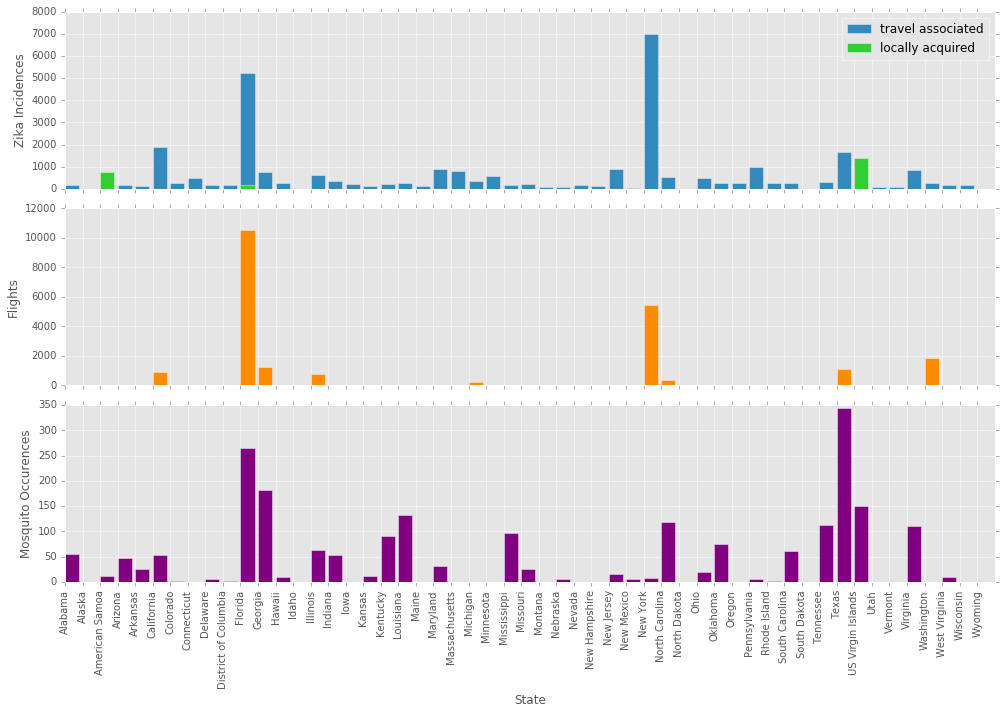

In [273]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14,10))
ind = np.arange(len(master_noPR))
ax1.bar(ind, zika_counts_noPR.zika_reported_travel, label='travel associated')
ax1.bar(ind, zika_counts_noPR.zika_reported_local, color='limegreen', label='locally acquired')
ax1.legend()
ax2.bar(ind, master_noPR.flights_oag, color='darkorange')
ax3.bar(ind, master_noPR.mosquito, color='purple')
ax2.set_ylabel('Flights')
ax1.set_ylabel('Zika Incidences')
ax3.set_ylabel('Mosquito Occurences')
ax3.set_xlabel('State')
labels = master_noPR.index
plt.xticks(ind,labels,rotation ='vertical')
#fig.suptitle('Zika Incidences, Flights, Mosquito Occurences by State', fontsize=20)
plt.tight_layout()
ax1.set_xlim(0,53)

plt.savefig('subcharts2.png', dpi=100)

In [67]:
def scatterplot(x,y,xname,yname):
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    ax.scatter(x, y)
    fit = np.polyfit(x, y, deg=1)
    ax.plot(x, fit[0] * x + fit[1])
    ax.set_xlim([-.05*max(x), max(x)*1.05])
    ax.set_ylim([-.05*max(y), max(y)*1.05])
    ax.annotate('corr = '+str(round(x.corr(y),3)),
                xy=(0.7,0.8), xycoords='axes fraction', fontsize=14)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_title(xname+' v. '+yname)
    plt.savefig('scatter_'+xname+'_'+yname+'.png', dpi=100)

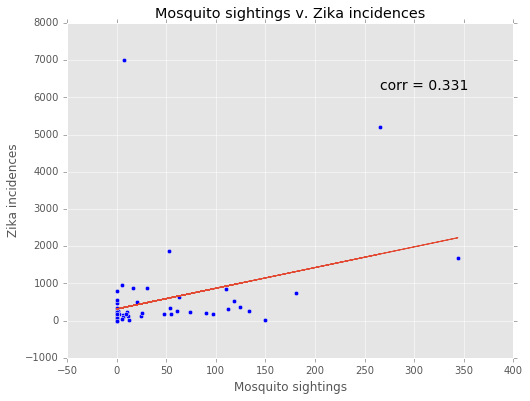

In [559]:
scatterplot(master.mosquito, master.zika_counts, 'Mosquito sightings','Zika incidences')

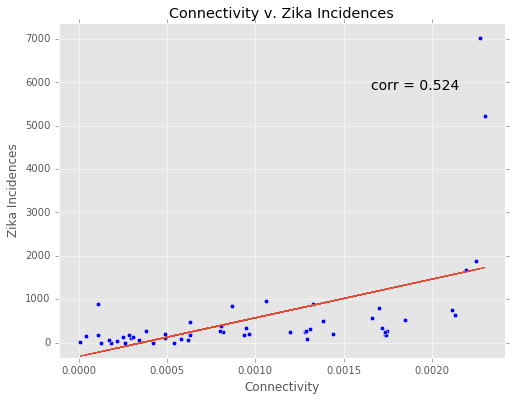

In [68]:
scatterplot(master.connectivity, master.zika_counts, 'Connectivity','Zika Incidences')

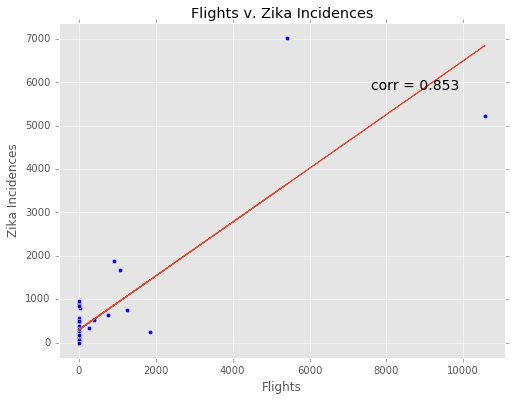

In [69]:
scatterplot(master.flights_oag, master.zika_counts, 'Flights','Zika Incidences')

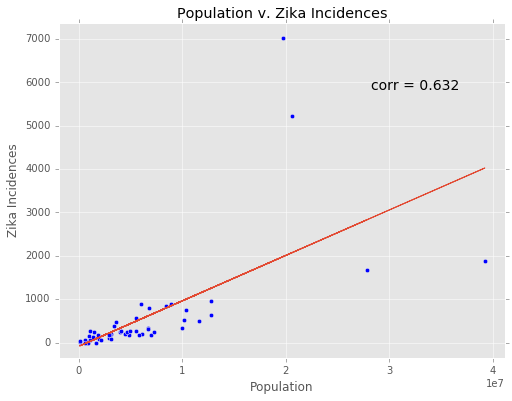

In [70]:
scatterplot(master['pop'], master.zika_counts, 'Population','Zika Incidences')

#### change in zika_counts

In [413]:
cdcUSA_travel2 = cdcUSA_travel.reset_index(level=['location','report_date'])
cdcUSA_diffs = cdcUSA_travel2.groupby('report_date').sum().diff()

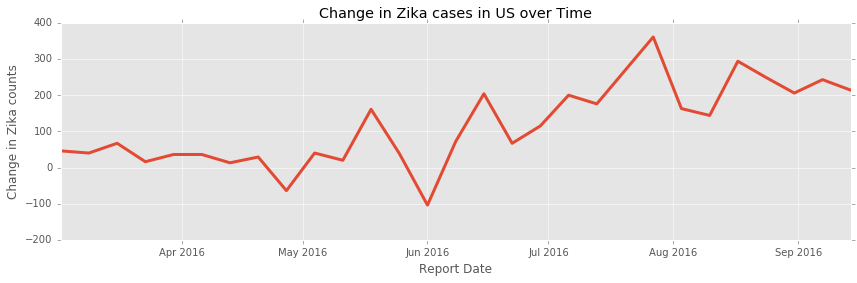

In [544]:
cdcUSA_diffs.set_index(cdcUSA_diffs.index.to_datetime(), inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(cdcUSA_diffs.index, cdcUSA_diffs.values, linewidth=3)
ax.set_ylabel('Change in Zika counts')
ax.set_xlabel('Report Date')
ax.set_title('Change in Zika cases in US over Time')
plt.tight_layout()

plt.savefig('zika_diffs.png', dpi=100)